# Logistic Regression

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

%matplotlib inline

## 2 - Task

In this part, we'll build a logistic regression model to predict whether a student gets admitted into a university.

### 2.1 Problem Statement

We have students exam results of a university department and we are going to determine each applicant’s chance of admission based on their results on two exams. 
* We have have historical data from previous applicants that you can use as a training set for logistic regression. 
* For each training example, we have the applicant’s scores on two exams and the admissions decision. 
* We are going to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

### 2.2 Loading and visualizing the data

We'll start by loading the dataset for this task. 
- `X_train` contains exam scores on two exams for a student
- `y_train` is the admission decision 
    - `y_train = 1` if the student was admitted 
    - `y_train = 0` if the student was not admitted 
- Both `X_train` and `y_train` are numpy arrays.


In [157]:
# Loading the dataset into dataframe
from pandas import read_csv
read_csv("students_exams_results.txt", names=["test_1", "test_2", "result"])

,test_1,test_2,result
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
...,...,...,...
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1


In [149]:
# load dataset
data = np.loadtxt("students_exams_results.txt", delimiter=',')
X_train = data[:,:2]
y_train = data[:,2]


#### View the variables
Let's get more familiar with the dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first five values of `X_train` and the type of the variable.

In [55]:
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First five elements in X_train are:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>


Now print the first five values of `y_train`

In [56]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in y_train are:
 [0. 0. 0. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


#### Checking the dimensions of variables

Another useful way to get familiar with the data is to view its dimensions. Let's print the shape of `X_train` and `y_train` and see how many training examples we have in our dataset.

In [62]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


#### Data Visualization

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.
- The code below displays the data on a 2D plot (as shown below), where the axes are the two exam scores, and the positive and negative examples are shown with different markers.


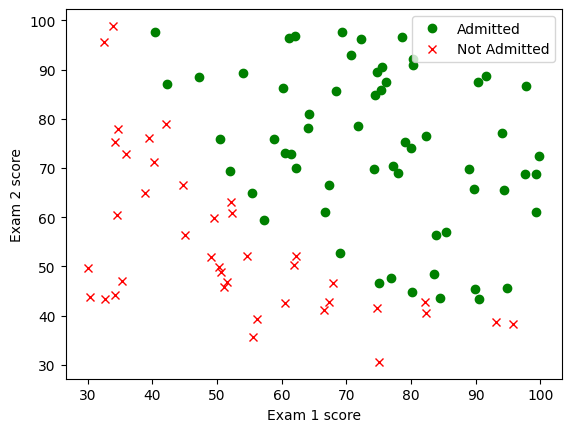

In [88]:
# Creating Boolean arrays
positive = y_train == 1
negative = y_train == 0

# Plot examples
plt.plot(X_train[positive, 0], X_train[positive, 1], 'go', label="Admitted")
plt.plot(X_train[negative, 0], X_train[negative, 1], 'rx', label="Not Admitted")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")    
plt.show()   

<a name="2.3"></a>
### 2.3  Sigmoid function

Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

Let's implement the sigmoid function first, so it can be used by the rest of this assignment.

Note that 
- `z` is not always a single number, but can also be an array of numbers. 
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

In [20]:
def sigmoid(z):

    g = 1./(1+np.exp(-z))
    
    return g

<a name="2.4"></a>
### 2.4 Cost function for logistic regression

Logistic Regression cost function

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is - 

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$

Note:
* `X_train` and `y_train` are not scalar values but matrices of shape ($m, n$) and ($𝑚$,1) respectively, where  $𝑛$ is the number of features and $𝑚$ is the number of training examples.
* We'll use the sigmoid function implemented above for this part.


In [32]:
def cost_function(X, y, w, b, *argv):

    m, n = X.shape

    # Calculate predicted values using vectorization
    # y_pred = 1. / (1 + np.exp(-(np.dot(X, w) + b)))
    y_pred = sigmoid(np.dot(X, w) + b)
    # Compute total cost using vectorized operations
    total_cost = np.sum(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred))
    total_cost /= m

    return total_cost

<a name="2.5"></a>
### 2.5 Gradient for logistic regression

Gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

In `compute_gradient` function, we are going to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label

In [40]:
def compute_gradient(X, y, w, b, *argv): 


    m, n = X.shape

    # Initialize gradients
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    # Calculate errors using vectorization
    err = sigmoid( np.dot(X, w) + b) - y

    # Compute gradients using vectorized operations
    dj_db = np.sum(err)
    dj_dw = np.dot(X.T, err)

    # Normalize gradients
    dj_dw /= m
    dj_db /= m


        
    return dj_db, dj_dw

### 2.6 Learning parameters using gradient descent 

#### Note :

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step. 

- The value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [42]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 

    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

In [44]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   cost_function, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.96   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


### 2.7 Decision boundary

We will now use the final parameters from gradient descent to plot the linear fit. If you implemented the previous parts correctly, you should see a plot similar to the following plot:   


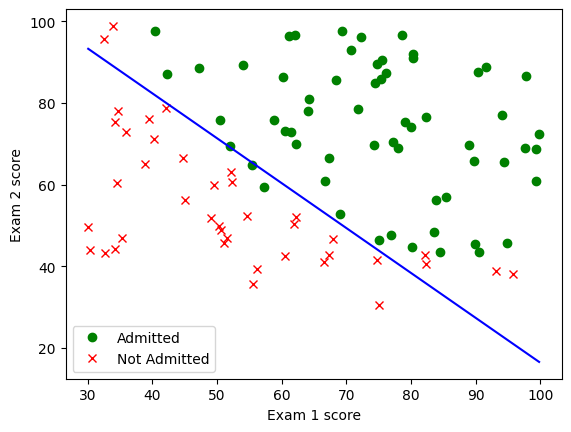

In [86]:
#plot_decision_boundary(w, b, X_train, y_train)

positive = y_train == 1
negative = y_train == 0

# Plot examples
plt.plot(X_train[positive, 0], X_train[positive, 1], 'go', label = "Admitted")
plt.plot(X_train[negative, 0], X_train[negative, 1], 'rx', label = "Not Admitted")

plot_x = np.array([min(X_train[:, 0]), max(X_train[:, 0])])
plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
    
plt.plot(plot_x, plot_y, c="b")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="lower left")
plt.show()

<a name="2.8"></a>
### 2.8 Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set. 

We'll implement the `predict` function below to do this.


The `predict` function will produce `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First we need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)} + b)$ for every example 
    - We've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, we've can used the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$
  

In [87]:
def predict(X, w, b): 

    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    # Loop over each example
    for i in range(m):   
        z_wb = 0
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb += X[i, j] * w[j]
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = 0 if f_wb < 0.5 else 1
        
    ### END CODE HERE ### 
    return p

Now that we've completed the function `predict`, let's run the code below to compute the accuracy on the training set

In [24]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000


## 3 - Regularized Logistic Regression

In this part, we'll explore the necessity for regularization term in the cost equation, However the boundary line seperating the the 2 classes will not linear and here is where regularization comes into play


### 3.1 Task

The dataset contains test results for microchips from a fabrication plant, with two tests conducted during quality assurance (QA). The task is to predict whether each microchip should be accepted or rejected based on the test results. 

We will built a slightly different logistic regression model from the previous one.

### 3.2 Loading and visualizing the data

Similar to previous parts, let's start by loading the dataset for this task and visualizing it. 

  - `X_train` contains the test results for the microchips from two tests
  - `y_train` contains the results of the QA  
      - `y_train = 1` if the microchip was accepted 
      - `y_train = 0` if the microchip was rejected 
  - Both `X_train` and `y_train` are numpy arrays.

In [158]:
# Loading the dataset into dataframe

read_csv("Microships_data.txt", names=["test_1", "test_2", "result"])

,test_1,test_2,result
0,0.051267,0.699560,1
1,-0.092742,0.684940,1
2,-0.213710,0.692250,1
3,-0.375000,0.502190,1
4,-0.513250,0.465640,1
...,...,...,...
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0


In [95]:
# load dataset
data = np.loadtxt("ex2data2.txt", delimiter=',')
X_train = data[:,:2]
y_train = data[:,2]


#### View the variables

The code below prints the first five values of `X_train` and `y_train` and the type of the variables.


In [96]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:",type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>
y_train: [1. 1. 1. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


#### Checking the dimensions of variables

Another useful way to get familiar with your data is to view its dimensions. Let's print the shape of `X_train` and `y_train` and see how many training examples we have in our dataset.

In [97]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
We have m = 118 training examples


#### Data Visualization

Using matplottib we are going to generate a figure like Figure 3, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with different markers.

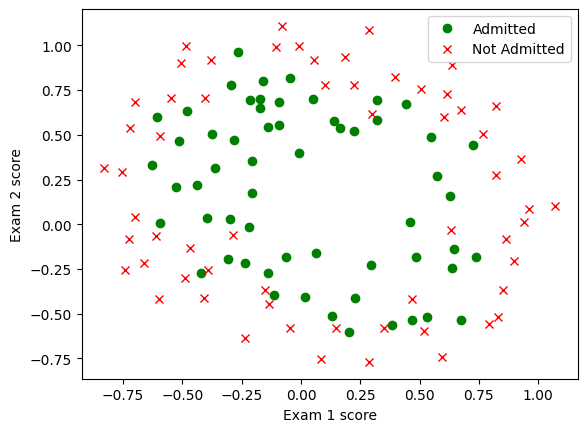

In [99]:
# Creating Boolean arrays
positive = y_train == 1
negative = y_train == 0

# Plot examples
plt.plot(X_train[positive, 0], X_train[positive, 1], 'go', label="Admitted")
plt.plot(X_train[negative, 0], X_train[negative, 1], 'rx', label="Not Admitted")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")    
plt.show() 

Figure 3 shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.


<a name="3.3"></a>
### 3.3 Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 
- We have provided the `map_feature` function for you in utils.py. 

In [139]:
def map_feature(X1, X2, degree):

    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)

    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)


In [115]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1],degree=6)
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


Let's also print the first elements of `X_train` and `mapped_X` to see the tranformation.

In [116]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. In the next parts of the exercise, we'll implement regularized logistic regression to fit the data and also see  how regularization can help combat the overfitting problem.


### 3.4 Cost function for regularized logistic regression

In this part, we'll implement the cost function for regularized logistic regression.

Recall that for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Comparing this to the cost function without regularization (which we've implemented above), which is of the form 

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.

The `compute_cost_reg` function below will calculate the following term for each element in $w$ 
$$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

The starter code then adds this to the cost without regularization (which we've computed above in `compute_cost`) to calculate the cost with regulatization.



In [126]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):

    m, n = X.shape
    
    # Calls the compute_cost function that you implemented above
    cost_without_reg = cost_function(X, y, w, b) 

    reg_cost = np.sum(w**2)*lambda_/(2*m)
    
    # Adding the regularization cost to get the total cost
    total_cost = cost_without_reg + reg_cost

    return total_cost

<a name="3.5"></a>
### 3.5 Gradient for regularized logistic regression

In this section, we are going implement the gradient for regularized logistic regression.


The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is a scalar, the other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^\mathrm{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})  $$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\, \text{for $j=0...(n-1)$}$$

Compare this to the gradient of the cost function without regularization (which you implemented above), which is of the form 
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$


As we can see,$\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same, the difference is the following term in $\frac{\partial J(\mathbf{w},b)}{\partial w}$, which is $$\frac{\lambda}{m} w_j  \quad\, \text{for $j=0...(n-1)$}$$ 





The `compute_gradient_reg` function will calculate the following term

$$\frac{\lambda}{m} w_j  \quad\, \text{for $j=0...(n-1)$}$$

The starter code will add this term to the $\frac{\partial J(\mathbf{w},b)}{\partial w}$ returned from `compute_gradient` above to get the gradient for the regularized cost function.

In [129]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 

    m, n = X.shape
    
    dj_db, dj_dw = compute_gradient(X, y, w, b)

    dj_dw += w * (lambda_ / m)        
        
    return dj_db, dj_dw

### 3.6 Learning parameters using gradient descent

Similar to the previous parts, we'll use your gradient descent function implemented above to learn the optimal parameters $w$,$b$. 

- After training our parameters, we will use it to plot the decision boundary. 


In [131]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1], degree = 6)
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )

dj_db: 0.07138288792343654
First few elements of regularized dj_dw:
 [-0.010386028450548701, 0.011409852883280116, 0.0536273463274574, 0.003140278267313463]


In [133]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ (you can try varying this)
lambda_ = 0.01    

# Hyperparameters settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   


<a name="3.7"></a>
### 3.7 Plotting the decision boundary
To help you visualize the model learned by this classifier, we will plot the (non-linear) decision boundary that separates the positive and negative examples. 

- We'll plotted the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then drew a contour plot of where the predictions change from y = 0 to y = 1.

- After learning the parameters $w$,$b$, the next step is to plot a decision boundary similar to Figure 4.


C:\Users\skander\AppData\Local\Temp\ipykernel_27816\393895767.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = sigmoid(np.dot(map_feature(u[i], v[j], degree = 6), w) + b)


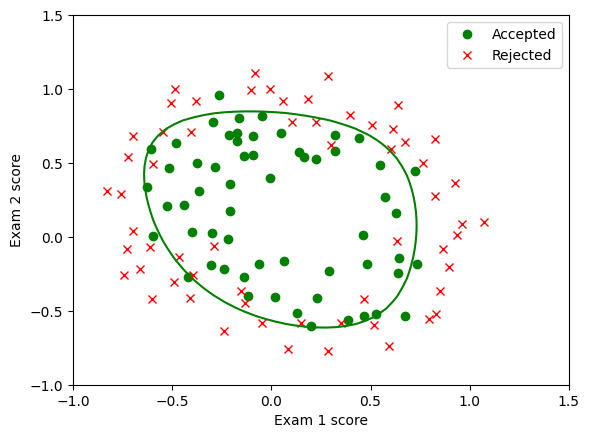

In [146]:
# Creating Boolean arrays
positive = y_train == 1
negative = y_train == 0

# Plot examples
plt.plot(X_train[positive, 0], X_train[positive, 1], 'go', label="Accepted")
plt.plot(X_train[negative, 0], X_train[negative, 1], 'rx', label="Rejected")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")    


u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)

z = np.zeros((len(u), len(v)))

# Evaluate z = theta*x over the grid
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = sigmoid(np.dot(map_feature(u[i], v[j], degree = 6), w) + b)

# important to transpose z before calling contour       
z = z.T

# Plot z = 0.5
plt.contour(u,v,z, levels = [0.5], colors="g")

plt.show() 


<a name="3.8"></a>
### 3.8 Evaluating regularized logistic regression model

We'll use the `predict` function that we've implemented above to calculate the accuracy of the regularized logistic regression model on the training set

In [147]:
#Compute accuracy on the training set
p = predict(X_mapped, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 82.203390
